In [2]:
import os
import torch
import PIL.Image as pil
from torchvision import transforms
from Models.EncoderModel import EncoderModel
from Models.DecoderModel import DepthDecoderModel, DepthDecoderModelESPCN, PoseDecoderModel
from Models.DisparityAdjustmentV2 import DisparityAdjustment

In [37]:
from Dataset.KITTI import KITTI
from torch.utils.data import DataLoader

datapath = "/scratch/mp6021/Monodepth2/data/KITTI"
trainfiles = open("/scratch/mp6021/Monodepth2/data/KITTI/splits/eigen_zhou/train_files.txt", "r").read().splitlines()
trainset = KITTI(datapath, trainfiles, 192, 640, [0, -1, 1], 4, True, True)
trainloader = DataLoader(trainset, 1, shuffle=True, num_workers=14, pin_memory=True, drop_last=True)

In [3]:
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
path = os.path.join("/scratch/am11533/depth-estimation/trained_models/MASKCAMLESS_ESPCN1", "weights_19")

In [6]:
enc = EncoderModel(50)
encoderDict = torch.load(os.path.join(path, "encoder.pth"), map_location=device)
height = encoderDict.pop("height")
width = encoderDict.pop("width")
enc.load_state_dict(encoderDict)
enc.to(device)
enc.eval()

EncoderModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [7]:
disparityAdj = DisparityAdjustment(device)

In [8]:
depthDecoder = DepthDecoderModelESPCN(enc.numChannels)
depthDecoder.load_state_dict(torch.load(os.path.join(path, "decoder.pth"), map_location=device))
depthDecoder.to(device)
depthDecoder.eval()

DepthDecoderModelESPCN(
  (decoder): ModuleList(
    (0): ConvBlock(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ELU(alpha=1.0)
    )
    (1): ESPCN(
      (conv1): Conv2d(256, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(32, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pixel_shuffle): PixelShuffle(upscale_factor=2)
    )
    (2): ConvBlock(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(1280, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ELU(alpha=1.0)
    )
    (3): ConvBlock(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (act): ELU(alpha=1.0)
    )
    (4): ESPCN(
      (conv1): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(64, 32, kernel_siz

In [89]:
for batchIdx, inputs in enumerate(trainloader):
    imgTensor = inputs[("color", 0, 0)].to(device)
    print(imgTensor.shape)
    with torch.no_grad():
        features = enc(imgTensor)
        outputs = depthDecoder(features)
        orig_img = (imgTensor[0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        pil.fromarray(orig_img).save("predictions/original_img.jpeg")
        #disp = outputs[("disp", 0)]
        disp = disparityAdj(imgTensor, outputs[("disp", 0)])
        #disp_resized = torch.nn.functional.interpolate(
        #                disp, (original_height, original_width), mode="bilinear", align_corners=False)
        #disp_resized_np = disp_resized.squeeze().cpu().numpy()
        disp_resized_np = disp.squeeze().cpu().numpy()
        vmax = np.percentile(disp_resized_np, 95)
        normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
        mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
        colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
        im = pil.fromarray(colormapped_im)
        im2 = np.vstack([orig_img, im])
    if batchIdx == 1:
        break

torch.Size([1, 3, 192, 640])
torch.Size([1, 3, 192, 640])


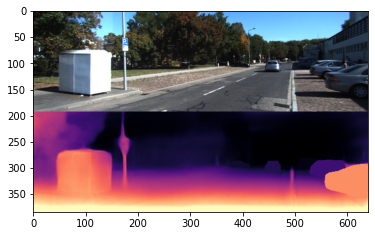

In [90]:
import matplotlib.pyplot as plt
plt.imshow(im2)

In [13]:
imgPath = "/scratch/mp6021/Monodepth2/predictions/custom.jpeg"
img = pil.open(imgPath).convert('RGB')
original_width, original_height = img.size
img = img.resize((width, height), pil.LANCZOS)
imgTensor = transforms.ToTensor()(img).unsqueeze(0)
imgTensor = imgTensor.to(device)

In [14]:
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np

In [15]:
with torch.no_grad():
    features = enc(imgTensor)
    outputs = depthDecoder(features)
    #disp = outputs[("disp", 0)]
    disp = disparityAdj(imgTensor, outputs[("disp", 0)])
    disp_resized = torch.nn.functional.interpolate(
                    disp, (original_height, original_width), mode="bilinear", align_corners=False)
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)
    normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
    colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
    im = pil.fromarray(colormapped_im)

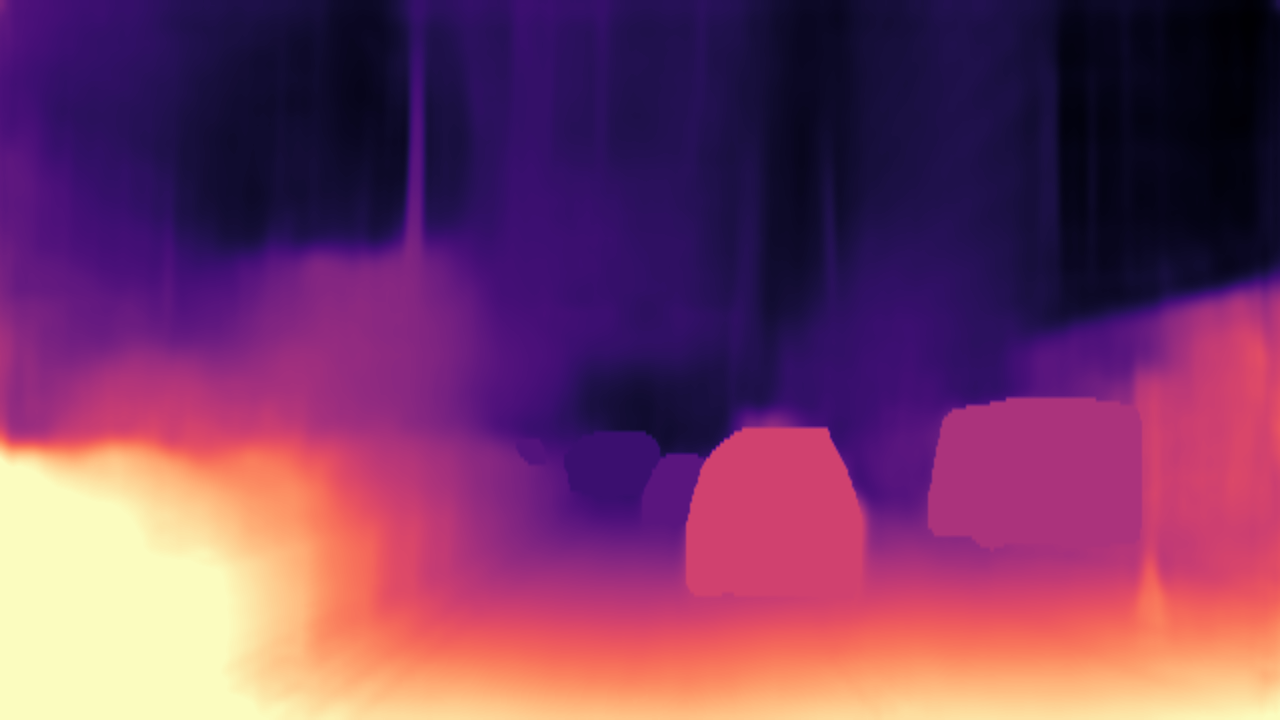

In [16]:
im

In [132]:
im.save("predictions/maskcamless_espcn.jpeg")